In [1]:
import networkx as nx

import numpy as np
import pandas as pd

import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib as mpl

import random
import math

from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

from lib.generators.LFR import LFR

In [2]:
def lfr_reconstruction_and_classification(mu, seed, n=1000, t1=3, t2=1.1):
    generator = LFR(n=n, t1=t1, t2=t2, m=mu, seed=seed)
    feature_names = generator.feature_names

    link_prediction_train, link_prediction_test, classifier_test = generator.TRAIN1_DF, generator.TEST1_DF, generator.TEST2_DF

    print('Fitting link prediction model')
    model =\
        GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=seed)\
        .fit(link_prediction_train[feature_names], link_prediction_train['goal'])

    prob = model.predict_proba(link_prediction_test[feature_names])[:, 1]
    prob = pd.Series(prob, name='prob')
    link_proba = link_prediction_test.join(prob)

    link_proba['abs_error'] = link_proba.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)

    train_median_error = link_proba['abs_error'].median()

    link_proba['quality_label'] = link_proba.apply(lambda row: 1 if row['abs_error'] <= train_median_error else 0, axis=1)

    print('Fitting classification model')
    model_2 =\
        GradientBoostingClassifier(n_estimators=500, max_depth=6, random_state=seed)\
        .fit(link_proba[feature_names], link_proba['quality_label'])

    print('Predicting quality classes')
    pred = model_2.predict(classifier_test[feature_names])
    pred = pd.Series(pred, name='predicted_quality_label')

    proba = model.predict_proba(classifier_test[feature_names])[:,1]
    proba = pd.Series(proba, name='prediction_probability')

    classifier_test = classifier_test.join(proba)
    classifier_test = classifier_test.join(pred)

    classifier_test['true_abs_error'] = classifier_test.apply(lambda row: math.fabs(row['goal']-row['prediction_probability']), axis=1)
    test_median_error = classifier_test['true_abs_error'].median()

    classifier_test['true_quality_label'] = classifier_test.apply(lambda row: 1 if row['true_abs_error'] <= test_median_error else 0, axis=1)

    print('Calculating metics')

    return\
        metrics.roc_auc_score(link_prediction_test['goal'], model.predict_proba(link_prediction_test[feature_names])[:, 1]),\
        metrics.roc_auc_score(classifier_test['true_quality_label'], model_2.predict_proba(classifier_test[feature_names])[:,1])

In [3]:
# hyperparameters

MU = [0.1, 0.33, 0.5, 0.66, 1]         # mu
seed = random.randint(1, 1000)         # random seed

In [4]:
rows_list = []

for mu in MU:
    print(f'For MU={mu} calculating:')
    p_auc, c_auc = lfr_reconstruction_and_classification(mu, seed, n=5000)
    rows_list.append({'mu': mu, 'reconstruction': p_auc, 'classification': c_auc})
    print('Done\n')

df = pd.DataFrame(rows_list, columns=['mu', 'reconstruction', 'classification'])
df

For MU=0.1 calculating:
Generating LFR graph...
Graph generated!
Train/test splitting...
Done splitting the data!
Calculating ['RAI', 'JC', 'AAI', 'PA'] features...
Done calculating
Fitting link prediction model
Fitting classification model
Predicting quality classes
Calculating metics
Done

For MU=0.33 calculating:
Generating LFR graph...
Graph generated!
Train/test splitting...
Done splitting the data!
Calculating ['RAI', 'JC', 'AAI', 'PA'] features...
Done calculating
Fitting link prediction model
Fitting classification model
Predicting quality classes
Calculating metics
Done

For MU=0.5 calculating:
Generating LFR graph...
Graph generated!
Train/test splitting...
Done splitting the data!
Calculating ['RAI', 'JC', 'AAI', 'PA'] features...
Done calculating
Fitting link prediction model
Fitting classification model
Predicting quality classes
Calculating metics
Done

For MU=0.66 calculating:
Generating LFR graph...
Graph generated!
Train/test splitting...
Done splitting the data!
Calcu

,mu,reconstruction,classification
0,0.10,0.711494,0.999573
1,0.33,0.711330,0.999617
2,0.50,0.682891,0.999857
3,0.66,0.706820,0.649345
4,1.00,0.704185,0.999864


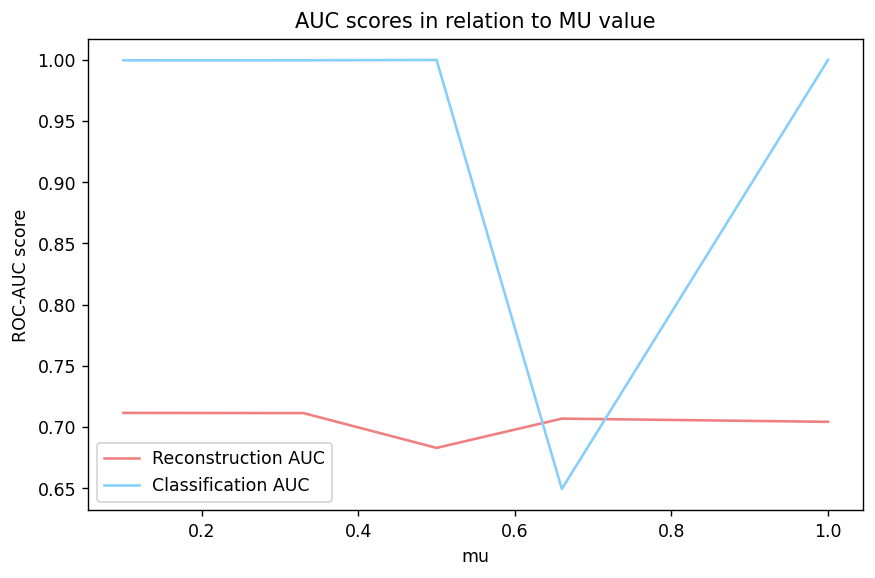

In [5]:
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 125

fig, ax = plt.subplots()

sn.lineplot( 
    x=df['mu'], 
    y=df['reconstruction'], 
    label='Reconstruction AUC',
    ax=ax, 
    color='lightcoral'
)

sn.lineplot( 
    x=df['mu'], 
    y=df['classification'], 
    label='Classification AUC',
    ax=ax, 
    color='lightskyblue'
)

ax.set_title("AUC scores in relation to MU value")
ax.set_ylabel("ROC-AUC score")
ax.legend()